# OpenAI Gym

https://github.com/openai/gym

In [1]:
import gym
import numpy as np 

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## CartPole problem

Full description: https://github.com/openai/gym/wiki/CartPole-v0

Some aspects have been copied below.

In [3]:
env = gym.make('CartPole-v0')

In [4]:
# Go to start state
env.reset()

array([-0.00097546, -0.03697588,  0.04474633,  0.00688688])

The state array has four variables corresponding to - 
#### Observation - Type: Box(4)

Num | Observation | Min | Max
---|---|---|---
0 | Cart Position | -2.4 | 2.4
1 | Cart Velocity | -Inf | Inf
2 | Pole Angle | ~ -41.8&deg; | ~ 41.8&deg;
3 | Pole Velocity At Tip | -Inf | Inf

#### Actions - Type: Discrete(2)

Num | Action
--- | ---
0 | Push cart to the left
1 | Push cart to the right


In [5]:
env.observation_space

Box(4,)

In [6]:
env.action_space

Discrete(2)

In [7]:
# Generate a random action
env.action_space.sample()

0

In [8]:
# Make an action!
action = env.action_space.sample() # or 0, 1
observation, reward, done, info = env.step(action)
print('Observation:', observation)
print('Reward:', reward)
print('Done:', done)
print('Info:', info)

Observation: [-0.00171498  0.15747673  0.04488407 -0.27134905]
Reward: 1.0
Done: False
Info: {}


In [9]:
# Keep moving the pole until it falls over
# The goal is to keep it up for as many steps as possible!
env.reset()
counter = 0
done = False
while not done:
    observation, reward, done, _ = env.step(env.action_space.sample())
    counter += 1
print('It took {} steps to fall down!'.format(counter))

It took 10 steps to fall down!


### Random search for linear model parameters

In [10]:
def model(state, w):
    return state.dot(w)

def action_from_model(state, w):
    m = model(state,w)
    if m < 0:
        return 0
    else:
        return 1

In [11]:
def play_episode(env, w):
    observation = env.reset()
    t = 0
    done = False
    while not done and t < 1e6: # set a maximum in case
        action = action_from_model(observation, w)
        observation, reward, done, _ = env.step(action)
        t += 1
    return t

In [12]:
def play_many_episodes(env, w, epochs):
    avg_steps = 0
    for i in range(epochs):
        steps = play_episode(env, w)
        avg_steps = (avg_steps * i + steps) / (i+1)
    return avg_steps

In [13]:
env = gym.make('CartPole-v0')

best_weights = None
best_avg_steps = 0
steps_list = []
for i in range(100):
    # random search parameters
    w = np.random.random(4)*2 - 1 # values -1,1 centred on 0
    # test each w 100 times
    avg_steps = play_many_episodes(env, w, 100)
    steps_list.append(avg_steps)
    
    if avg_steps > best_avg_steps:
        best_avg_steps = avg_steps
        best_weights = w

In [14]:
print(best_avg_steps)

200.0


In [15]:
play_many_episodes(env, best_weights, 100)

200.0

Note that there is a hard coded maximum of 200 steps allowed! This triggers the done flag.

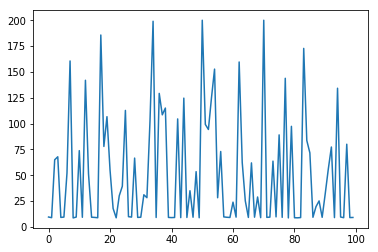

In [16]:
plt.plot(steps_list)

## Saving a video of the agent

(Note this is a little buggy in the notebook)

In [17]:
# from gym import wrappers

# env_mon = wrappers.Monitor(env, 
#                        'my_folder', # directory to save video in
#                        force=True # clear the past files in directory
#                       )
# # print(play_episode(env_mon, best_weights))
# print(play_episode(env_mon, w))

---

### Binned problem

Convert continuous states to binned

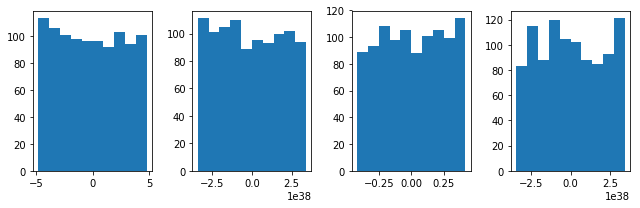

In [18]:
samples = 1000
X = np.zeros((samples,4))
for i in range(samples):
    x = env.observation_space.sample()
    X[i] = x

fig, axarr = plt.subplots(1,4, figsize=(9,3))
axarr[0].hist(X[:,0])
axarr[1].hist(X[:,1])
axarr[2].hist(X[:,2])
axarr[3].hist(X[:,3])
plt.tight_layout()
plt.show()

In [19]:
import os
import sys
import pandas as pd 
from datetime import datetime

In [27]:
class FeatureTransformer:
    
    def __init__(self):
        # transform one data point at a time
        nbins = 10
        self.cart_position_bins = np.linspace(-2.4, 2.4, nbins-1)
        self.cart_velocity_bins = np.linspace(-2, 2, nbins-1)
        self.pole_angle_bins    = np.linspace(-0.4, 0.4, nbins-1)
        self.pole_velocity_bins = np.linspace(-3.5, 3.5, nbins-1)
        self.all_bins = [self.cart_position_bins, 
                         self.cart_velocity_bins,
                         self.pole_angle_bins,
                         self.pole_velocity_bins]
        self.nbins = nbins
        
    def _build_state(self, features):
        return int(''.join(map(str, features)))

    def _to_bin(self, value, bins):
        return np.digitize(value, bins)
    
    def transform(self, observation):
        return self._build_state([self._to_bin(obs, bins)
                for obs, bins in zip(observation, self.all_bins)
               ])


In [28]:
class Model:
    
    def __init__(self, env, feature_transformer):
        self.env = env
        self.ft = feature_transformer
        
        num_states = ft.nbins**env.observation_space.shape[0]
        num_actions = env.action_space.n
        self.Q = np.random.uniform(
            low=-1, 
            high=1, 
            size=(num_states, num_actions)
        )
        
    def predict(self, obs):
        s = self.ft.transform(obs)
        # return array Q(s,a) over all actions for given s
        return self.Q[s]
    
    def update(self, s, a, G):
        # update Q using gradient descent
        # G = target return
        x = self.ft.transform(s)
        self.Q[x,a] += 1e-3*(G - self.Q[x,a])
        
    def sample_action(self, obs, eps):
        # epsilon-greedy
        if np.random.random() < eps:
            return int(self.env.action_space.sample())
        else:
            q = self.predict(obs)
            return int(np.argmax(q))

In [22]:
def play_one(model, eps, gamma):
    observation = model.env.reset()
    done = False
    t = 0
    total_reward = 0
    while not done: 
        last_observation = observation
        action = model.sample_action(observation, eps)
        observation, reward, done, _ = env.step(action)
        total_reward += reward
        
        # if fell over before getting to max 200 steps
        if done and t < 199:
            reward = -300
        
        # Q learning equation
        G = reward + gamma * np.max(model.predict(observation))
        model.update(last_observation, action, G)
        t += 1
        
    return total_reward

In [186]:
def plot_running_avg(totalrewards):
    N = len(totalrewards)
    running_avg = np.empty(N)
    for i in range(N):
        running_avg[i] = totalrewards[max(0,i-100):i+1].mean()
    plt.plot(running_avg)
#     plt.show()

In [ ]:
env = gym.make('CartPole-v0')
ft = FeatureTransformer()
model = Model(env,ft)
gamma = 0.9
N = 10000
totalrewards = np.empty(N)
for n in range(N):
    eps = 1.0 / np.sqrt(n+1)
    totalrewards[n] = play_one(model, eps, gamma)
    if n % 1000 == 0:
        print(n, totalrewards[max(0,n-100):n+1].mean())

plot_running_avg(totalrewards)

### Using RBF kernels

Now transform featuers using RBF kernels and fit the features using a linear model, using SGD to update at each step

In [67]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor

In [63]:
# we need to get data to fit the RBFSampler so do this by 
# generating many observation states to understand the 
# distribution. (observation_space.sample does it uniformly)
def play_episode(env, w):
    observations = []
    rewards = []
    observation = env.reset()
    t = 0
    done = False
    while not done and t < 1e6: # set a maximum in case
        action = env.action_space.sample()
        observation, reward, done, _ = env.step(action)
        t += 1
        observations.append(observation)
        rewards.append(reward)
    return np.array(observations), np.array(rewards)

In [64]:
def get_observation_examples(env):
    observations_all = []
    for i in range(1000):
        w = np.random.random(4)
        observations_per_episode, _ = play_episode(env, w)
        observations_all.append(observations_per_episode)
    return np.concatenate(observations_all)

In [65]:
observation_examples = get_observation_examples(env)
observation_examples.shape

(21882, 4)

In [72]:
class Transformer:
    
    def __init__(self):
        self.scaler = StandardScaler()
        rbf_gammas = [0.01, 0.1, 0.5, 1.0]
        rbf_samplers = [RBFSampler(gamma=g, n_components=1000, random_state=42) for g in rbf_gammas]
        self.featurizer = FeatureUnion([("rbf{}".format(i), rbf_samplers[i]) for i in range(4)])

    def fit(self, observation_examples):
        self.scaler.fit(observation_examples)
        self.featurizer.fit(self.scaler.transform(observation_examples))
        
    def transform(self, observations):
        scaled = self.scaler.transform(observations)
        return self.featurizer.transform(scaled)


In [76]:
ft = Transformer()
ft.fit(observation_examples)
nfeatures = ft.transform(observation_examples[:1]).shape[1]
print(nfeatures)

4000


In [172]:
# Here we have a model for each action (0 or 1) given state s
class Model:
    def __init__(self, label, env, learning_rate, transformer):
        self.label = label  # action label
        self.env = env
        self.sgd = SGDRegressor(learning_rate=learning_rate)
        self.ft = transformer
        # do a dummy fit so we can call predict
        self.sgd.partial_fit(self.ft.transform([env.reset()]), [0])
        
    def predict(self, s):
        x = self.ft.transform([s])
        return self.sgd.predict(x)
    
    def update(self, s, G):
        x = self.ft.transform([s])
        # here we want to update the weights of the linear model
        self.sgd.partial_fit(x, [G])
        
def sample_action(models, env, s, eps):
    if np.random.random() < eps:
        return env.action_space.sample()
    else:
        return best_action(models, s)

def best_action(models, s):
    q = [m.predict(s)[0] for m in models]
    return np.argmax(q)

def best_action_value(models, s):
    q = [m.predict(s)[0] for m in models]
    return np.max(q)

In [178]:
def play_one_episode(models, env, eps, gamma):
    s = env.reset()
    t = 0
    done = False
    totalreward = 0
    while not done and t < 200: 
        action = sample_action(models, env, s, eps)
        next_s, reward, done, _ = env.step(action)
        
        # if didn't reach the maximum of 200 penalise
        if done and t < 199:
            reward = -200

        # now get Q(s', a') using Q learning
        Q = best_action_value(models, next_s)
        G = reward + gamma * Q
        models[action].update(s, G)
        
        s = next_s
        t += 1
        totalreward += reward
        
    return t

In [182]:
learning_rate = 'constant'
eps = 0.1
gamma = 0.99

models = []
for a in range(env.action_space.n):
    models.append(Model(a, env, learning_rate, ft))

max_steps = []
for i in range(200):
    eps = 1.0 / np.sqrt(i+1)
    max_step = play_one_episode(models, env, eps, gamma)
    max_steps.append(max_step)
    
# plot_running_avg(np.array(max_steps))

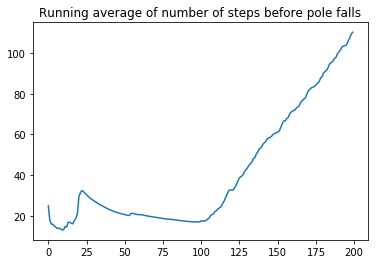

In [187]:
plot_running_avg(np.array(max_steps))
plt.title('Running average of number of steps before pole falls')
plt.show()